# There's Gold in Them Hills... right?

It's time for a little bit of Minecraft Myth Busting, as X would say.

Allegedly, gold is much easier to find in the Badlands with a uniform density from y=32 up to y=256

![ore distribution 1.18-1.20.1](../_static/ore_chart.png)

but at higher y-levels, most of the badlands is made up of terracotta, and I've never seen any type of ore in the middle of terracotta. So should you _really_ be digging into the hearts of mountains to look for gold? Or are you better off searching at, say, y~40?

## Creating a Test World

Rather than analyze one of my existing worlds, I chose to create a new one from scratch, first using [chunkbase to find a world with a good-sized badland](https://www.chunkbase.com/apps/seed-map#-1099639228980812746), then generating that world in a vanilla Minecraft 1.20 instance, teleporting to the center of the badlands,

![Badland to the bone](../_static/badlands.png)

letting the chunks generate, then using [MCA Selector](https://github.com/Querz/mcaselector) to trim out all the non-badlands biomes.

I also teleported to (0, 128, 0) in the nether to generate some nether chunks for comparison.

## Imports, Setup and Macros

In [1]:
import json
from collections import Counter, defaultdict
from os import environ
from pathlib import Path
from typing import Any, Collection, Dict, List, Tuple

import matplotlib.pyplot as plt
import mutf8
import pandas as pd
from IPython.display import Markdown, display
from nbt import nbt, region

In [2]:
save_folder = Path(environ["SAVE_PATH"])

In [3]:
def summarize_keystore(keystore: Dict[str, Any]) -> None:
    """Display a summary of the contents of a key-value store

    Parameters
    ----------
    keystore : dict
        The keystore to summarize

    Returns
    -------
    None
    """

    def _summarize_keystore(keystore: Dict[str, Any]) -> str:
        summary = ""
        for k, v in keystore.items():
            summary += f"\n - `{k}` : "
            if isinstance(v, (str, nbt.TAG_String)):
                summary += f'`"{v}"`'
            elif not isinstance(v, Collection):
                summary += f"`{str(v)}`"
            else:
                length = len(v)
                if 0 < length < 3:
                    summary += "\n"
                    if not isinstance(v, Dict):
                        v = {i: item for i, item in enumerate(v)}
                    summary += "\n".join(
                        (f"\t{line}" for line in _summarize_keystore(v).split("\n"))
                    )
                else:
                    summary += f"({len(v)} items)"
        return summary

    display(Markdown(_summarize_keystore(keystore)))

In [4]:
def split_block_value(value: int) -> List[int]:
    """Split a 64-bit int into 16x 4-bit ints

    Parameters
    ----------
    value: 64-bit int
        The int to split

    Returns
    -------
    list of 16x 4-bit ints
    """
    small_ints: List[int] = []
    for _ in range(16):
        value, remainder = divmod(value, 2**4)
        small_ints.insert(0, remainder)
    return small_ints

In [5]:
def get_region_and_chunk(
    coords: tuple[int, int, int]
) -> tuple[tuple[int, int], tuple[int, int, int]]:
    """Given a set of coordinates return the corresponding
    region file and chunk

    Parameters
    ----------
    (int, int, int)
        The block coordinates

    Returns
    -------
    str
        The region index
    (int, int, int)
        The chunk index (including y-sliced sub-chunk)
    """
    chunk: tuple[int, int, int] = tuple(coord // 16 for coord in coords)  # type: ignore
    region = (chunk[0] // 32, chunk[2] // 32)
    return region, chunk

## Chunk Contents

Cribbing from the [Iron Vein finding notebook](Finding%20an%20Iron%20Vein.ipynb), the name of the game is combing through each chunklet and finding the ones *containing* the blocks we want, then finding out *how many* such blocks are in that chunklet.

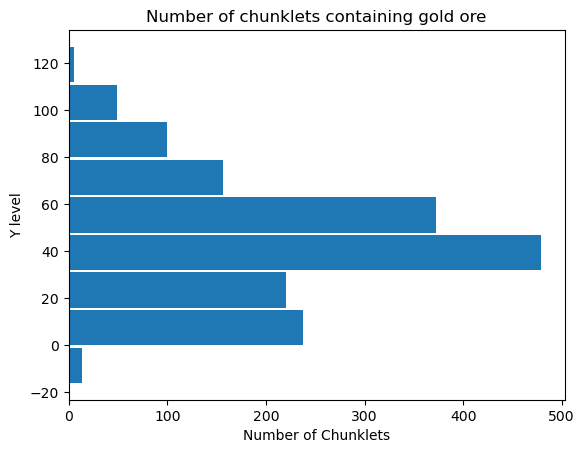

CPU times: user 1.47 s, sys: 158 ms, total: 1.62 s
Wall time: 1.48 s


In [6]:
%%time
n_chunks = 0
gold_chunklets: dict[int, list[nbt.TAG_Compound]] = defaultdict(list)
for region_file in sorted((save_folder / "region").glob("*")):
    if region_file.name == "r.0.0.mca":
        continue
    region_data = region.RegionFile(region_file)
    for chunk in region_data.iter_chunks():
        n_chunks += 1
        for section in chunk["sections"]:
            # explicitly ignoring deepslate gold ore
            if "minecraft:gold_ore" in [
                block["Name"].value for block in section["block_states"]["palette"]
            ]:
                gold_chunklets[section["Y"].value * 16].append(section)

fig, ax = plt.subplots()
ax.barh(
    *zip(*((y, len(chunklets)) for y, chunklets in gold_chunklets.items())),
    height=15,
    align="edge",
)
ax.set_title("Number of chunklets containing gold ore")
ax.set_ylabel("Y level")
ax.set_xlabel("Number of Chunklets")
plt.show(fig)

Now let's convert that to total ore.

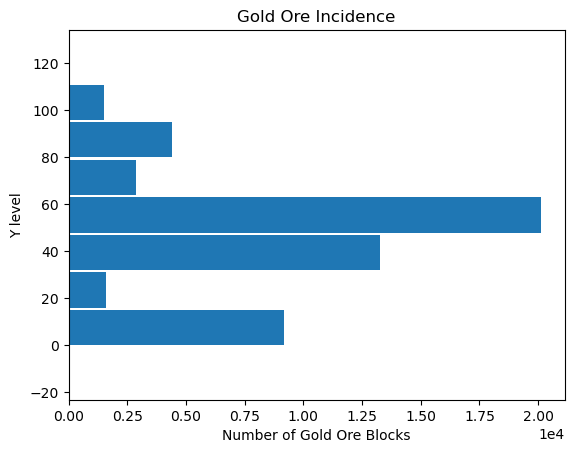

CPU times: user 3.5 s, sys: 122 ms, total: 3.62 s
Wall time: 3.48 s


In [7]:
%%time
gold_count: dict[int, int] = {}
for y, chunklets in gold_chunklets.items():
    ore_count = 0
    for chunklet in chunklets:
        palette: list[str] = [
            block["Name"].value for block in chunklet["block_states"]["palette"]
        ]
        ore_idx = palette.index("minecraft:gold_ore")
        block_counts = Counter(
            sum(
                [split_block_value(v) for v in chunklet["block_states"]["data"]],
                [],
            )
        )
        ore_count += block_counts.get(ore_idx, 0)
    gold_count[y] = ore_count

fig, ax = plt.subplots()
ax.barh(
    *zip(*gold_count.items()),
    height=15,
    align="edge",
)
ax.set_title("Gold Ore Incidence")
ax.set_ylabel("Y level")
ax.set_xlabel("Number of Gold Ore Blocks")
ax.ticklabel_format(axis="x", style="sci", scilimits=(-4, 4))
plt.show(fig)

So in terms of _absolute_ quantity of ores, you're actually better off mining at y=48-64, which is interesting!

## Normalized Counts

But what about if we subtract air, water, etc and look at percentage of _mineable_ blocks?

In [8]:
# blockz: set[str] = set()
# for region_file in sorted((save_folder / "region").glob("*")):
#     region_data = region.RegionFile(region_file)
#     for chunk in region_data.iter_chunks():
#         n_chunks += 1
#         for section in chunk["sections"]:
#             blockz.update( [
#                 block["Name"].value for block in section["block_states"]["palette"]
#             ])
# blockz

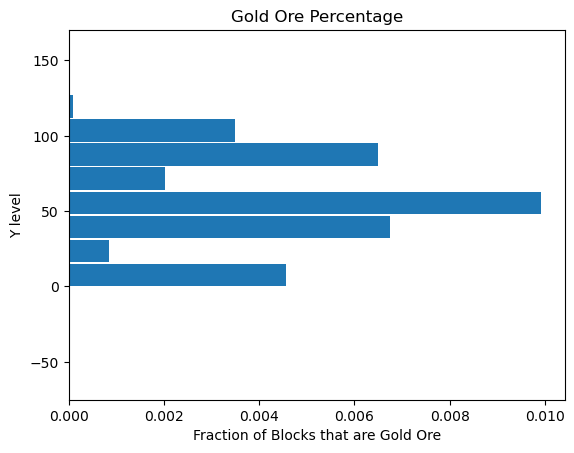

CPU times: user 13.2 s, sys: 141 ms, total: 13.4 s
Wall time: 13.2 s


In [9]:
%%time

gold_count = defaultdict(int)
denominator: dict[int, int] = defaultdict(int)
for region_file in sorted((save_folder / "region").glob("*")):
    if region_file.name == "r.0.0.mca":
        continue
    region_data = region.RegionFile(region_file)
    for chunk in region_data.iter_chunks():
        for section in chunk["sections"]:
            if "data" not in section["block_states"]:
                # then it's all a single block,
                # probably air or water
                continue
            block_counts = Counter(
                sum(
                    [split_block_value(v) for v in section["block_states"]["data"]],
                    [],
                )
            )
            block_lookup: list[str] = [
                block["Name"].value for block in section["block_states"]["palette"]
            ]
            ore_count = 0
            mineable_block_count = 0
            for i, count in block_counts.items():
                if block_lookup[i] == "minecraft:gold_ore":
                    # this could just be "="
                    ore_count += count
                if block_lookup[i] not in (
                    "minecraft:air",
                    "minecraft:water",
                    "minecraft:lava",
                    # there are actually a ton more "non-full blocks"
                    # like torches, cobwebs and dandelions
                    # but we'll assume those are rounding errors
                ):
                    mineable_block_count += count

            gold_count[section["Y"].value * 16] += ore_count
            denominator[section["Y"].value * 16] += mineable_block_count

ys = sorted(gold_count.keys())
pcts = [gold_count[y] / denominator[y] for y in ys]

fig, ax = plt.subplots()
ax.barh(
    ys,
    pcts,
    height=15,
    align="edge",
)
ax.set_title("Gold Ore Percentage")
ax.set_ylabel("Y level")
ax.set_xlabel("Fraction of Blocks that are Gold Ore")
ax.ticklabel_format(axis="x", style="sci", scilimits=(-4, 4))
plt.show(fig)

So even subtracting out the air (and water and lava) blocks, y=48-64 is the way to go! But I'm still skeptical that I'm supposed to be finding gold mixed in with terracotta. Does gold ore maybe only generate in areas without terracotta?

In [10]:
%%time

terracotta_to_gold_ratios: list[float] = []
stone_to_gold_ratios: list[float] = []
n = 0

for region_file in sorted((save_folder / "region").glob("*")):
    if region_file.name == "r.0.0.mca":
        continue
    region_data = region.RegionFile(region_file)
    for chunk in region_data.iter_chunks():
        for section in chunk["sections"]:
            if "data" not in section["block_states"]:
                continue
            if section["Y"].value * 16 != 48:
                continue
            n += 1
            block_counts = Counter(
                sum(
                    [split_block_value(v) for v in section["block_states"]["data"]],
                    [],
                )
            )
            block_lookup = [
                block["Name"].value for block in section["block_states"]["palette"]
            ]
            ore_count = 0
            terracotta_count = 0
            stone_count = 0
            for i, count in block_counts.items():
                if block_lookup[i] == "minecraft:gold_ore":
                    # this could just be "="
                    ore_count += count
                elif block_lookup[i] in (
                    "minecraft:stone",
                    "minecraft:andesite",
                    "minecraft:diorite",
                    "minecraft:granite",
                ):
                    stone_count += count
                elif block_lookup[i].endswith("terracotta"):
                    terracotta_count += count
            if ore_count == 0:
                continue

            terracotta_to_gold_ratios.append(terracotta_count / ore_count)
            stone_to_gold_ratios.append(stone_count / ore_count)

CPU times: user 2.47 s, sys: 4 ms, total: 2.48 s
Wall time: 2.48 s


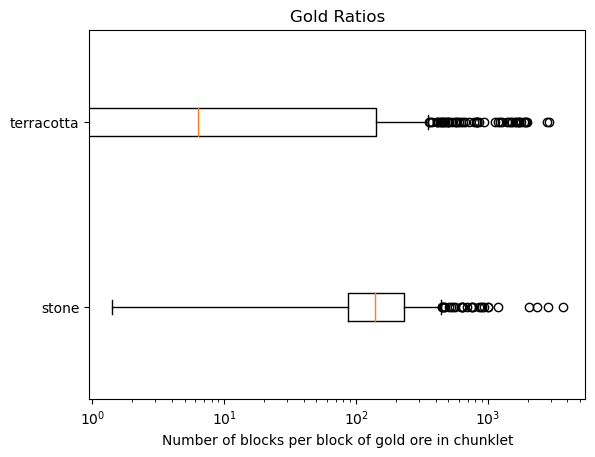

In [11]:
fig, ax = plt.subplots()
ax.boxplot(
    (stone_to_gold_ratios, terracotta_to_gold_ratios),
    vert=False,
    labels=("stone", "terracotta"),
)
ax.set_title("Gold Ratios")
ax.set_xlabel("Number of blocks per block of gold ore in chunklet")
ax.set_xscale("log")
plt.show(fig)

Yeah, bingo--**gold does not generate within terracotta**, so if you're digging in terracotta, you're too high up.

## Best y level?

So far we've been working with 16-block-tall "chunklets," which is good enough for a rough analysis, but it's not enough to tell us *precisely* which y-level to dig at to get gold. The reason is that the block data is just one 4096-length ($16^3$) array, with [nothing in the wiki](https://minecraft.fandom.com/wiki/Chunk_format#NBT_structure) saying how to convert from index to (x, y, z).

But we should probably be able to figure it out emprically.

First, let's take a random chunklet and get the indices of some gold ore blocks.

In [12]:
%%time
for region_file in sorted((save_folder / "region").glob("*")):
    if region_file.name == "r.0.0.mca":
        continue
    region_data = region.RegionFile(region_file)
    for chunk in region_data.iter_chunks():
        for section in chunk["sections"]:
            if "data" not in section["block_states"]:
                continue
            if section["Y"].value * 16 != 48:
                continue
            palette = [
                block["Name"].value for block in section["block_states"]["palette"]
            ]
            if "minecraft:gold_ore" not in palette:
                continue
            gold_idx = palette.index("minecraft:gold_ore")
            indices = [
                i
                for i, idx in enumerate(
                    sum(
                        [split_block_value(v) for v in section["block_states"]["data"]],
                        [],
                    )
                )
                if idx == gold_idx
            ]
            if len(indices) == 0:
                continue
            break
        else:
            continue
        break
    else:
        continue
    break
chunklet_coords = (
    chunk["xPos"].value * 16,
    section["Y"].value * 16,
    chunk["zPos"].value * 16,
)
print(
    f"Found a chunklet with {len(indices)} gold blocks"
    f" with corner at {chunklet_coords}"
)

Found a chunklet with 38 gold blocks with corner at (-1536, 48, -512)
CPU times: user 10.4 ms, sys: 4.11 ms, total: 14.5 ms
Wall time: 13.3 ms


Let's look at the first one:

In [13]:
def split_into_coords(idx: int) -> tuple[int, int, int]:
    """Convert an index into three coordinates.
    We don't yet know which coordinate is which.

    Parameters
    ----------
    idx : int
        A number between 0 and 4095 (inclusive)

    Returns
    -------
    (int, int, int) tuple
        The three coordinate values separated.
    """
    coord_1, remainder = divmod(idx, 16 * 16)
    coord_2, remainder = divmod(remainder, 16)
    return (coord_1, coord_2, remainder)


def print_possible_coordinates(idx: int, chunklet_corner: tuple[int, int, int]) -> None:
    """Print all six possible coordinates corresponding to a given index

    Parameters
    ----------
    idx : int
        A number between 0 and 4095 (inclusive)

    Returns
    -------
    None
    """
    coord = split_into_coords(idx)
    print(
        "(x, y, z)",
        "->",
        (
            chunklet_corner[0] + coord[0],
            chunklet_corner[1] + coord[1],
            chunklet_corner[2] + coord[2],
        ),
    )
    print(
        "(x, z, y)",
        "->",
        (
            chunklet_corner[0] + coord[0],
            chunklet_corner[1] + coord[2],
            chunklet_corner[2] + coord[1],
        ),
    )
    print(
        "(y, x, z)",
        "->",
        (
            chunklet_corner[0] + coord[1],
            chunklet_corner[1] + coord[0],
            chunklet_corner[2] + coord[2],
        ),
    )
    print(
        "(y, z, x)",
        "->",
        (
            chunklet_corner[0] + coord[1],
            chunklet_corner[1] + coord[2],
            chunklet_corner[2] + coord[0],
        ),
    )
    print(
        "(z, x, y)",
        "->",
        (
            chunklet_corner[0] + coord[2],
            chunklet_corner[1] + coord[0],
            chunklet_corner[2] + coord[1],
        ),
    )
    print(
        "(z, y, x)",
        "->",
        (
            chunklet_corner[0] + coord[2],
            chunklet_corner[1] + coord[1],
            chunklet_corner[2] + coord[0],
        ),
    )

In [14]:
print_possible_coordinates(indices[0], chunklet_coords)

(x, y, z) -> (-1532, 57, -512)
(x, z, y) -> (-1532, 48, -503)
(y, x, z) -> (-1527, 52, -512)
(y, z, x) -> (-1527, 48, -508)
(z, x, y) -> (-1536, 52, -503)
(z, y, x) -> (-1536, 57, -508)


Now we just load up the game and see what we see.

***A few minutes later...***

I tied to `/clone` each of these blocks to my postion and ended up with *literally* nothing but stone.

But I thought of a better idea:

![Galaxy Brain](../_static/fill_then_search.png)

In [15]:
get_region_and_chunk((1, 2, 3))

((0, 0), (0, 0, 0))

In [16]:
region_data = region.RegionFile(save_folder / "region" / "r.0.0.mca")

In [17]:
chunk = region_data.get_chunk(0, 0)

In [18]:
chunklet = chunk["sections"][4]
assert chunklet["Y"].value == 0

In [19]:
palette = [block["Name"].value for block in chunklet["block_states"]["palette"]]

debris_idx = palette.index("minecraft:ancient_debris")
indices = [
    i
    for i, idx in enumerate(
        sum(
            [split_block_value(v) for v in section["block_states"]["data"]],
            [],
        )
    )
    if idx == debris_idx
]
print(f"The ancient debris is at index {indices[0]}")

The ancient debris is at index 297


In [20]:
print_possible_coordinates(indices[0], (0, 0, 0))

(x, y, z) -> (1, 2, 9)
(x, z, y) -> (1, 9, 2)
(y, x, z) -> (2, 1, 9)
(y, z, x) -> (2, 9, 1)
(z, x, y) -> (9, 1, 2)
(z, y, x) -> (9, 2, 1)


In what universe does *that* make sense?

#### But the important bit

is that the middle value is the y-value which... honestly, is pretty surprising (I would have expected it to be the most or least significant value)

### Redoing by y-level

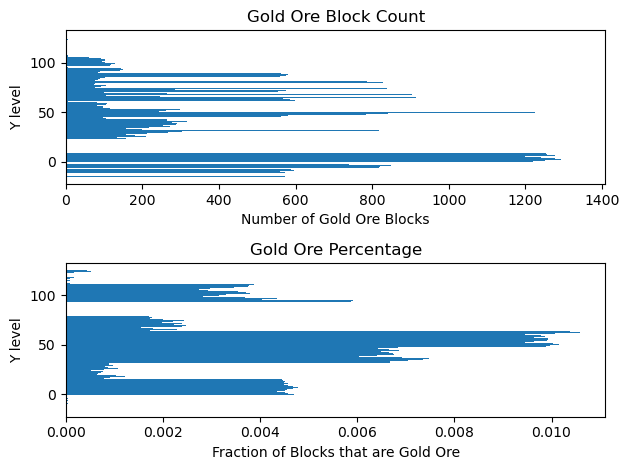

CPU times: user 26.3 s, sys: 153 ms, total: 26.4 s
Wall time: 26.2 s


In [21]:
%%time
gold_count = defaultdict(int)
denominator = defaultdict(int)
for region_file in sorted((save_folder / "region").glob("*")):
    if region_file.name == "r.0.0.mca":
        continue
    region_data = region.RegionFile(region_file)
    for chunk in region_data.iter_chunks():
        for section in chunk["sections"]:
            if "data" not in section["block_states"]:
                continue

            block_lookup = [
                block["Name"].value for block in section["block_states"]["palette"]
            ]
            for idx, i in enumerate(
                sum(
                    [split_block_value(v) for v in section["block_states"]["data"]],
                    [],
                )
            ):
                y = section["Y"].value * 16 + (idx // 16 % 16)

                if block_lookup[i] == "minecraft:gold_ore":
                    # this could just be "="
                    gold_count[y] += 1

                if block_lookup[i] not in (
                    "minecraft:air",
                    "minecraft:water",
                    "minecraft:lava",
                ):
                    denominator[y] += 1


ys = sorted(gold_count.keys())
pcts = [gold_count[y] / denominator[y] for y in ys]

fig, axs = plt.subplots(2, 1)
axs[0].barh(
    ys,
    gold_count.values(),
    height=0.9,
    align="center",
)
axs[0].set_title("Gold Ore Block Count")
axs[0].set_ylabel("Y level")
axs[0].set_xlabel("Number of Gold Ore Blocks")
axs[0].ticklabel_format(axis="x", style="sci", scilimits=(-4, 4))

axs[1].barh(
    ys,
    pcts,
    height=0.9,
    align="center",
)
axs[1].set_title("Gold Ore Percentage")
axs[1].set_ylabel("Y level")
axs[1].set_xlabel("Fraction of Blocks that are Gold Ore")
axs[1].ticklabel_format(axis="x", style="sci", scilimits=(-4, 4))
fig.tight_layout()
plt.show(fig)

That's a lot messier than I would have expected. Given that my method is already failing to extract z, this is giving me very little faith that I'm getting y correct either.